In [45]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import os, sys, json
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.data_loading import load_emorynlp, load_isear, load_tess, filter_emotions, load_emodb, load_ravdess, load_iemocap, load_meld
from src.processor import FileProcessor
from tqdm import tqdm
tqdm.pandas()

# ===========
# 1) load dataframe
#train_df = load_emorynlp(split='train')
#val_df = load_emorynlp(split='dev')
#test_df = load_emorynlp(split='test')
#isear = filter_emotions(load_isear())
#ISEAR
#df = pd.read_csv("hf://datasets/gsri-18/ISEAR-dataset-complete/ISEAR_dataset_complete.csv")
#df['label'], df['text'] = df['emotion'], df['content']

#emodb = pd.read_csv("EmoDB_transcripts.csv")[['text', 'label']]
#tess = pd.read_csv("TESS_transcripts.csv")[['text', 'label']]
iemocap_transc = pd.read_csv("IEMOCAP_transcripts.csv")#[['text', 'label']]
iemocap_true = filter_emotions(load_iemocap())
meld = pd.read_csv("MELD_transcripts.csv")#[['text', 'label']]


meld.dropna(inplace=True)
print(meld.info())
#iemocap['text'].fillna("NA")
#meld['text'].fillna("NA")
# Merge (join) on utterance_id
iemocap = pd.merge(iemocap_transc, iemocap_true, on="filename", how="inner")
iemocap.dropna(inplace=True)
iemocap['Utterance'] = iemocap['text']
iemocap['text'] = iemocap['transcription']


#df = filter_emotions(load_crema_d())
#processor = FileProcessor()
#df['text'] = df['filename'].progress_apply(lambda x: processor.process_file(x)['text'])
#df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2546 entries, 0 to 2609
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2546 non-null   int64 
 1   Utterance     2546 non-null   object
 2   Speaker       2546 non-null   object
 3   Emotion       2546 non-null   object
 4   Sentiment     2546 non-null   object
 5   Dialogue_ID   2546 non-null   int64 
 6   Utterance_ID  2546 non-null   int64 
 7   Season        2546 non-null   int64 
 8   Episode       2546 non-null   int64 
 9   StartTime     2546 non-null   object
 10  EndTime       2546 non-null   object
 11  filename      2546 non-null   object
 12  label         2546 non-null   object
 13  text          2546 non-null   object
dtypes: int64(5), object(9)
memory usage: 298.4+ KB
None


In [54]:
import pandas as pd
from jiwer import process_words, wer
from tqdm import tqdm
tqdm.pandas()

import re

def normalize_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation and special characters (keep words and spaces)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # 3. Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    if len(text)==0:
        text = "NA"
    
    return text

# Function to compute WER metrics for each pair
def compute_wer_metrics(row):
    ref = row["Utterance"]
    hyp = row["text"]

    measures = process_words(ref, hyp)
    return pd.Series({
        "WER": measures.wer,
        "S_ratio": measures.substitutions / len(measures.references[0]),
        "D_ratio": measures.deletions / len(measures.references[0]),
        "I_ratio": measures.insertions / len(measures.references[0]),
        "Hits_ratio": measures.hits / len(measures.references[0]) 
    })

df = pd.concat([iemocap])
df["Utterance"] = df['Utterance'].apply(normalize_text)
df["text"] = df['text'].apply(normalize_text)
# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)

# Combine with original DataFrame
df_results = pd.concat([df, df_metrics], axis=1)

ref_corpus = " ".join(df["Utterance"])
hyp_corpus = " ".join(df["text"])

global_wer = wer(ref_corpus, hyp_corpus)
print(f"Global WER: {global_wer:.3f}")

df_metrics.mean(axis=0)


100%|██████████| 4615/4615 [00:00<00:00, 11697.52it/s]


Global WER: 0.166


WER           0.238256
S_ratio       0.116416
D_ratio       0.040713
I_ratio       0.081128
Hits_ratio    0.842872
dtype: float64

In [48]:
335/2546

0.13157894736842105

In [55]:
df = pd.concat([meld])
df["Utterance"] = df['Utterance'].apply(normalize_text)
df["text"] = df['text'].apply(normalize_text)

# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)

# Combine with original DataFrame
df_results = pd.concat([df, df_metrics], axis=1)

ref_corpus = " ".join(df["Utterance"])
hyp_corpus = " ".join(df["text"])

global_wer = wer(ref_corpus, hyp_corpus)
print(f"Global WER: {global_wer:.3f}")

df_metrics.mean(axis=0)

100%|██████████| 2546/2546 [00:00<00:00, 12860.54it/s]


Global WER: 0.385


WER           0.821767
S_ratio       0.176025
D_ratio       0.082399
I_ratio       0.563343
Hits_ratio    0.741576
dtype: float64

In [51]:
df_results[df_results.WER>=1.0]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label,text,WER,S_ratio,D_ratio,I_ratio,Hits_ratio
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,You know what?,1.0,0.500000,0.00,0.500000,0.500000
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,Push,1.0,1.000000,0.00,0.000000,0.000000
8,24,"Let's I was justyeah, right.",Joey,joy,positive,1,5,1,23,"00:10:55,780","00:11:01,242",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,"Let's get... I was just... Yeah, okay.",1.0,0.600000,0.00,0.400000,0.400000
9,25,Push!,Joey,joy,positive,1,6,1,23,"0:11:01,410","0:11:01,828",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,"Push, push, push!",3.0,1.000000,0.00,2.000000,0.000000
10,26,Push!,Joey,joy,positive,1,7,1,23,"0:11:01,828","0:11:03,774",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,Push! Push!,1.0,0.000000,0.00,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2749,Gimme them!,Monica,anger,negative,279,0,6,4,"0:14:04,176","0:14:06,058",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,Give me a note they are mine.,3.5,1.000000,0.00,2.500000,0.000000
2595,2750,No! They are mine!,Rachel,anger,negative,279,1,6,4,"0:14:06,058","0:14:06,438",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,Bye!,1.0,0.250000,0.75,0.000000,0.000000
2598,2753,Gimme them!,Monica,anger,negative,279,4,6,4,"00:14:08,848","00:14:10,431",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,Give me a kiss!,2.0,1.000000,0.00,1.000000,0.000000
2602,2757,Well,Rachel,neutral,neutral,279,8,6,4,"0:14:28,200","0:14:28,784",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,Well...,1.0,1.000000,0.00,0.000000,0.000000


In [2]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['label'])
#test_df = iemocap

test_df.head()

,text,label
216,It's nothing to freak out about.,neutral
1752,Yes.,neutral
1207,"Yeah, that's fine.",neutral
2107,I also said number one.,neutral
1747,"No, you can't let this stop you from getting ...",sad


In [ ]:


# ===========
# 2) encode labels (string -> int)
# ===========
le = LabelEncoder()
le.fit(train_df["label"])

train_df["label_id"] = le.transform(train_df["label"])
val_df["label_id"]   = le.transform(val_df["label"])
test_df["label_id"]  = le.transform(test_df["label"])

id2label = {i: l for i, l in enumerate(le.classes_)}
label2id = {l: i for i, l in id2label.items()}

print("Classes:", id2label)


# ===========
# 3) Convert pandas -> Hugging Face Dataset
# ===========
train_ds = Dataset.from_pandas(train_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
val_ds   = Dataset.from_pandas(val_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]].rename(columns={"label_id":"labels"}))

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

# ===========
# 4) Tokenizer & model
# ===========
model_name = "albert-base-v2" # MELD - 
#model_name = "distilbert-base-multilingual-cased"
#model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
#model_name = "xlm-roberta-base"
#model_name = "cardiffnlp/twitter-xlm-roberta-base-emotion"#"distilroberta-base"
#model_name = "meta-llama/Llama-3.2-1B" #"cardiffnlp/twitter-xlm-roberta-base-emotion"
tok = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tok(batch["text"], truncation=True, max_length=64) #128



dataset_tok = dataset.map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tok)

cfg = AutoConfig.from_pretrained(model_name, num_labels=len(le.classes_), id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

# ===========
# 5) Metrics
# ===========
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# ===========
# 6) Trainer
# ===========
args = TrainingArguments(
    output_dir=model_name+"_train",#"mdistilbert_emotions",
    #eval_strategy="epoch",
    evaluation_strategy="epoch",#"epoch",
    save_strategy="epoch",
    learning_rate=5e-3,#5e-5,
    per_device_train_batch_size=4,#16,
    per_device_eval_batch_size=8,#32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", #"f1_macro",
    logging_steps=50,
    report_to="none",
    #fp16=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_tok["train"],
    eval_dataset=dataset_tok["validation"],
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# ===========
# 7) Train and evaluate
# ===========
trainer.train()
print("Final test results:", trainer.evaluate(dataset_tok["test"]))

# distilbert emodb+tess--iemocap 3ep 21,09

Classes: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Map: 100%|██████████| 382/382 [00:00<00:00, 43330.29 examples/s]
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Wed Sep 10 18:03:35 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--f1/34c46321f42186df33a6260966e34a368f14868d9cc2ba47d142112e2800d233 (last modified on Wed Sep 10 18:03:36 2025) since it couldn't be found locally at eva

{'loss': 2.8079, 'learning_rate': 0.004887892376681614, 'epoch': 0.11}


  5%|▍         | 102/2230 [00:14<03:38,  9.73it/s]

{'loss': 3.8789, 'learning_rate': 0.0047757847533632285, 'epoch': 0.22}


  7%|▋         | 152/2230 [00:19<02:57, 11.71it/s]

{'loss': 2.7581, 'learning_rate': 0.004663677130044844, 'epoch': 0.34}


  9%|▉         | 201/2230 [00:24<03:19, 10.15it/s]

{'loss': 2.344, 'learning_rate': 0.004551569506726457, 'epoch': 0.45}


 11%|█▏        | 251/2230 [00:28<02:50, 11.60it/s]

{'loss': 2.8005, 'learning_rate': 0.004439461883408072, 'epoch': 0.56}


 13%|█▎        | 301/2230 [00:33<03:00, 10.66it/s]

{'loss': 2.508, 'learning_rate': 0.004327354260089686, 'epoch': 0.67}


 16%|█▌        | 351/2230 [00:38<02:42, 11.53it/s]

{'loss': 2.1864, 'learning_rate': 0.0042152466367713, 'epoch': 0.78}


 18%|█▊        | 401/2230 [00:42<02:36, 11.68it/s]

{'loss': 2.3863, 'learning_rate': 0.0041031390134529154, 'epoch': 0.9}


                                                  
 20%|██        | 446/2230 [00:51<02:30, 11.88it/s]

{'eval_loss': 2.065119981765747, 'eval_accuracy': 0.4816753926701571, 'eval_f1_macro': 0.0928823826350328, 'eval_runtime': 5.2726, 'eval_samples_per_second': 72.45, 'eval_steps_per_second': 9.104, 'epoch': 1.0}


 20%|██        | 451/2230 [00:52<15:07,  1.96it/s]

{'loss': 2.4463, 'learning_rate': 0.003991031390134529, 'epoch': 1.01}


 23%|██▎       | 502/2230 [00:56<02:28, 11.67it/s]

{'loss': 2.6628, 'learning_rate': 0.003878923766816144, 'epoch': 1.12}


 25%|██▍       | 552/2230 [01:01<02:22, 11.77it/s]

{'loss': 2.5575, 'learning_rate': 0.0037668161434977576, 'epoch': 1.23}


 27%|██▋       | 602/2230 [01:05<02:19, 11.70it/s]

{'loss': 2.9481, 'learning_rate': 0.0036547085201793722, 'epoch': 1.35}


 29%|██▉       | 652/2230 [01:09<02:15, 11.66it/s]

{'loss': 1.9495, 'learning_rate': 0.003542600896860987, 'epoch': 1.46}


 31%|███▏      | 702/2230 [01:13<02:09, 11.83it/s]

{'loss': 2.4296, 'learning_rate': 0.003430493273542601, 'epoch': 1.57}


 34%|███▎      | 752/2230 [01:18<02:07, 11.61it/s]

{'loss': 2.3123, 'learning_rate': 0.0033183856502242153, 'epoch': 1.68}


 36%|███▌      | 802/2230 [01:22<02:01, 11.79it/s]

{'loss': 2.1183, 'learning_rate': 0.0032062780269058295, 'epoch': 1.79}


 38%|███▊      | 852/2230 [01:26<01:56, 11.82it/s]

{'loss': 2.3127, 'learning_rate': 0.003094170403587444, 'epoch': 1.91}


                                                  
 40%|████      | 892/2230 [01:31<02:29,  8.92it/s]

{'eval_loss': 2.387507200241089, 'eval_accuracy': 0.02617801047120419, 'eval_f1_macro': 0.00728862973760933, 'eval_runtime': 1.5279, 'eval_samples_per_second': 250.012, 'eval_steps_per_second': 31.415, 'epoch': 2.0}


 40%|████      | 902/2230 [01:33<03:24,  6.49it/s]

{'loss': 2.4033, 'learning_rate': 0.0029820627802690583, 'epoch': 2.02}


 43%|████▎     | 950/2230 [01:37<01:50, 11.54it/s]

{'loss': 2.3826, 'learning_rate': 0.0028699551569506725, 'epoch': 2.13}


 45%|████▍     | 1002/2230 [01:41<01:45, 11.65it/s]

{'loss': 2.1259, 'learning_rate': 0.002757847533632287, 'epoch': 2.24}


 47%|████▋     | 1052/2230 [01:46<01:41, 11.60it/s]

{'loss': 2.3724, 'learning_rate': 0.0026457399103139013, 'epoch': 2.35}


 49%|████▉     | 1102/2230 [01:50<01:38, 11.49it/s]

{'loss': 1.9971, 'learning_rate': 0.002533632286995516, 'epoch': 2.47}


 52%|█████▏    | 1152/2230 [01:55<01:33, 11.48it/s]

{'loss': 1.9667, 'learning_rate': 0.00242152466367713, 'epoch': 2.58}


 54%|█████▍    | 1202/2230 [01:59<01:27, 11.77it/s]

{'loss': 2.1385, 'learning_rate': 0.0023094170403587444, 'epoch': 2.69}


 56%|█████▌    | 1252/2230 [02:03<01:22, 11.82it/s]

{'loss': 1.9962, 'learning_rate': 0.0021973094170403586, 'epoch': 2.8}


 58%|█████▊    | 1302/2230 [02:07<01:16, 12.10it/s]

{'loss': 2.0241, 'learning_rate': 0.002085201793721973, 'epoch': 2.91}


                                                   
 60%|██████    | 1338/2230 [02:12<01:18, 11.36it/s]

{'eval_loss': 2.06929349899292, 'eval_accuracy': 0.4816753926701571, 'eval_f1_macro': 0.0928823826350328, 'eval_runtime': 1.4629, 'eval_samples_per_second': 261.12, 'eval_steps_per_second': 32.811, 'epoch': 3.0}


 61%|██████    | 1352/2230 [02:13<01:41,  8.62it/s]

{'loss': 1.9243, 'learning_rate': 0.0019730941704035874, 'epoch': 3.03}


 63%|██████▎   | 1402/2230 [02:17<01:11, 11.60it/s]

{'loss': 2.1714, 'learning_rate': 0.001860986547085202, 'epoch': 3.14}


 65%|██████▌   | 1452/2230 [02:22<01:05, 11.91it/s]

{'loss': 1.9455, 'learning_rate': 0.0017488789237668162, 'epoch': 3.25}


 67%|██████▋   | 1502/2230 [02:26<01:01, 11.93it/s]

{'loss': 1.9014, 'learning_rate': 0.0016367713004484304, 'epoch': 3.36}


 70%|██████▉   | 1552/2230 [02:30<00:58, 11.59it/s]

{'loss': 1.9098, 'learning_rate': 0.0015246636771300448, 'epoch': 3.48}


 72%|███████▏  | 1602/2230 [02:34<00:53, 11.83it/s]

{'loss': 1.9613, 'learning_rate': 0.001412556053811659, 'epoch': 3.59}


 74%|███████▍  | 1652/2230 [02:39<00:50, 11.37it/s]

{'loss': 1.8454, 'learning_rate': 0.0013004484304932735, 'epoch': 3.7}


 76%|███████▋  | 1702/2230 [02:43<00:45, 11.60it/s]

{'loss': 1.9344, 'learning_rate': 0.0011883408071748879, 'epoch': 3.81}


 79%|███████▊  | 1752/2230 [02:47<00:42, 11.29it/s]

{'loss': 1.7784, 'learning_rate': 0.0010762331838565023, 'epoch': 3.92}


                                                   
 80%|████████  | 1784/2230 [02:52<01:02,  7.14it/s]

{'eval_loss': 2.2482292652130127, 'eval_accuracy': 0.4816753926701571, 'eval_f1_macro': 0.0928823826350328, 'eval_runtime': 1.4728, 'eval_samples_per_second': 259.365, 'eval_steps_per_second': 32.59, 'epoch': 4.0}


 81%|████████  | 1801/2230 [02:54<00:44,  9.67it/s]

{'loss': 1.8206, 'learning_rate': 0.0009641255605381166, 'epoch': 4.04}


 83%|████████▎ | 1851/2230 [02:58<00:32, 11.65it/s]

{'loss': 1.5994, 'learning_rate': 0.0008520179372197309, 'epoch': 4.15}


 85%|████████▌ | 1901/2230 [03:02<00:28, 11.54it/s]

{'loss': 1.7673, 'learning_rate': 0.0007399103139013453, 'epoch': 4.26}


 87%|████████▋ | 1951/2230 [03:06<00:23, 11.81it/s]

{'loss': 1.6927, 'learning_rate': 0.0006278026905829596, 'epoch': 4.37}


 90%|████████▉ | 2001/2230 [03:11<00:19, 11.80it/s]

{'loss': 1.5978, 'learning_rate': 0.000515695067264574, 'epoch': 4.48}


 92%|█████████▏| 2051/2230 [03:15<00:15, 11.75it/s]

{'loss': 1.7515, 'learning_rate': 0.00040358744394618836, 'epoch': 4.6}


 94%|█████████▍| 2101/2230 [03:19<00:11, 11.56it/s]

{'loss': 1.7593, 'learning_rate': 0.0002914798206278027, 'epoch': 4.71}


 96%|█████████▋| 2151/2230 [03:24<00:06, 11.69it/s]

{'loss': 1.6073, 'learning_rate': 0.00017937219730941703, 'epoch': 4.82}


 99%|█████████▊| 2201/2230 [03:28<00:02, 11.97it/s]

{'loss': 1.6338, 'learning_rate': 6.72645739910314e-05, 'epoch': 4.93}


                                                   
100%|██████████| 2230/2230 [03:32<00:00, 11.63it/s]

{'eval_loss': 1.527614712715149, 'eval_accuracy': 0.4816753926701571, 'eval_f1_macro': 0.0928823826350328, 'eval_runtime': 1.4825, 'eval_samples_per_second': 257.681, 'eval_steps_per_second': 32.379, 'epoch': 5.0}


100%|██████████| 2230/2230 [03:32<00:00, 10.49it/s]


{'train_runtime': 212.6754, 'train_samples_per_second': 41.895, 'train_steps_per_second': 10.485, 'train_loss': 2.1627641053477746, 'epoch': 5.0}


100%|██████████| 48/48 [00:02<00:00, 17.83it/s]

Final test results: {'eval_loss': 2.091597557067871, 'eval_accuracy': 0.4790575916230366, 'eval_f1_macro': 0.09254108723135271, 'eval_runtime': 2.7417, 'eval_samples_per_second': 139.327, 'eval_steps_per_second': 17.507, 'epoch': 5.0}


{'loss': 24.9592, 'grad_norm': 1.0552517175674438, 'learning_rate': 0.048660235798499464, 'epoch': 0.08}
{'loss': 1.5166, 'grad_norm': 0.22348372638225555, 'learning_rate': 0.04732047159699893, 'epoch': 0.16}
{'loss': 1.3658, 'grad_norm': 0.3004882335662842, 'learning_rate': 0.045980707395498394, 'epoch': 0.24}
{'loss': 1.3918, 'grad_norm': 0.25394704937934875, 'learning_rate': 0.04464094319399786, 'epoch': 0.32}
{'loss': 1.3852, 'grad_norm': 0.3115262985229492, 'learning_rate': 0.04330117899249732, 'epoch': 0.4}
{'loss': 1.3673, 'grad_norm': 0.3080769181251526, 'learning_rate': 0.04196141479099679, 'epoch': 0.48}
{'loss': 1.3941, 'grad_norm': 0.1880466192960739, 'learning_rate': 0.04062165058949625, 'epoch': 0.56}

In [4]:
from sklearn.metrics import classification_report

preds = trainer.predict(dataset_tok["test"])
print(classification_report(preds.label_ids, np.argmax(preds.predictions, axis=1), target_names=le.classes_))


100%|██████████| 48/48 [00:01<00:00, 33.04it/s]

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        50
     disgust       0.00      0.00      0.00        10
        fear       0.00      0.00      0.00         8
       happy       0.00      0.00      0.00        59
     neutral       0.48      1.00      0.65       183
         sad       0.00      0.00      0.00        31
    surprise       0.00      0.00      0.00        41

    accuracy                           0.48       382
   macro avg       0.07      0.14      0.09       382
weighted avg       0.23      0.48      0.31       382



## Experiment 4

In [2]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import os, sys
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.recognizers import TextEmotionRecognizer
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
df = test_df

NameError: name 'test_df' is not defined

100%|██████████| 382/382 [02:02<00:00,  3.11it/s]

              precision    recall  f1-score   support

       angry       0.31      0.24      0.27        50
     disgust       0.05      0.10      0.07        10
        fear       0.07      0.12      0.09         8
       happy       0.30      0.12      0.17        59
     neutral       0.80      0.17      0.29       183
         sad       0.28      0.16      0.20        31
    surprise       0.13      0.73      0.22        41

    accuracy                           0.23       382
   macro avg       0.28      0.24      0.19       382
weighted avg       0.51      0.23      0.24       382



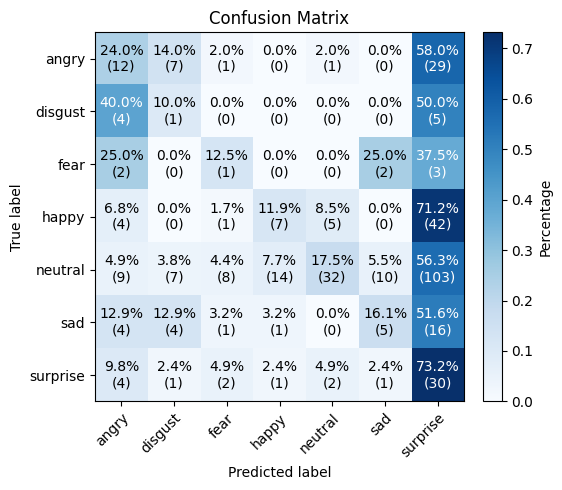

In [4]:
ter = TextEmotionRecognizer("gemma3:4b")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

100%|██████████| 382/382 [03:25<00:00,  1.85it/s]

              precision    recall  f1-score   support

       angry       0.40      0.24      0.30        50
     disgust       0.11      0.20      0.14        10
        fear       0.08      0.12      0.10         8
       happy       0.40      0.10      0.16        59
     neutral       0.58      0.65      0.61       183
         sad       0.67      0.19      0.30        31
    surprise       0.21      0.46      0.29        41

    accuracy                           0.43       382
   macro avg       0.35      0.28      0.27       382
weighted avg       0.47      0.43      0.42       382



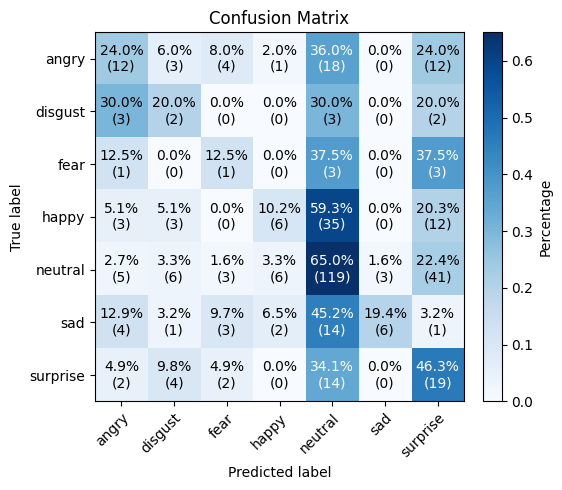

In [5]:
ter = TextEmotionRecognizer("gemma2")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

In [ ]:
ter = TextEmotionRecognizer("gemma")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

 38%|███▊      | 147/382 [01:06<01:39,  2.36it/s]

In [ ]:
ter = TextEmotionRecognizer("qwen")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

In [ ]:
ter = TextEmotionRecognizer("glm4")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

In [ ]:
ter = TextEmotionRecognizer("mistral")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

In [4]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 24.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 37.1 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

# -----------------
# Embedding Transformers
# -----------------
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        tokenized = [t.split() for t in X]
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size,
                              window=self.window, min_count=self.min_count, workers=4)
        return self

    def transform(self, X):
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.model.wv[w] for w in tokens if w in self.model.wv]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)


class GloVeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100):
        self.size = size
        self.glove = None

    def fit(self, X, y=None):
        # load pretrained GloVe from gensim (small version)
        self.glove = api.load(f'glove-wiki-gigaword-{self.size}')
        return self

    def transform(self, X):
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.glove[w] for w in tokens if w in self.glove]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)


# -----------------
# Experiment Function
# -----------------
def run_experiment(df):
    X = df['text']
    y = df['label']

    loo = LeaveOneOut()

    classifiers = {
        'SVM': (SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
        'RandomForest': (RandomForestClassifier(), {'clf__n_estimators': [50, 100]}),
        'NaiveBayes': (GaussianNB(), {}),
        'LogReg': (LogisticRegression(max_iter=500), {'clf__C': [0.1, 1, 10]})
    }

    embeddings = {
        'Word2Vec': Word2VecTransformer(size=100),
        'GloVe': GloVeTransformer(size=100)
    }

    results = {}

    for emb_name, emb in embeddings.items():
        for clf_name, (clf, params) in classifiers.items():
            pipe = Pipeline([
                ('emb', emb),
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid=params, cv=loo, scoring='accuracy', n_jobs=-1)
            grid.fit(X, y)

            results[(emb_name, clf_name)] = grid.best_score_

    return results




In [ ]:
results = run_experiment(df)
print("Results:")
for k, v in results.items():
    print(k, v)